# Fusion of Gyro + Magnetometer for Yaw

[Tutorial by Matlab](https://www.youtube.com/watch?v=0rlvvYgmTvI)


In [3]:
import serial
import struct
import numpy as np
import time
from scipy.spatial.transform import Rotation as Rot
import matplotlib.pyplot as plt
np.set_printoptions(precision=2)
np.set_printoptions(suppress=True)

mean_calib = np.array([-0.03399272, -0.03970689,  1.00875861-1,  3.2031734 ,  1.91866194,-0.69563943,0,0,0])
mean_calib = np.array([ 0.03, -0.02,  0.03, -0.4 , -0.45,  0.22,  0.  ,  0.  ,  0.  ])
mean_calib = np.array([-0.00228715,  0.02340559, -0.00697907,  0.42290122,  0.61993788, 2.52639569,  0.        ,  0.        ,  0.        ]) # changes for each imu sensor


# Kalman Filter types 
(explained later)

In [6]:
dt = 0.001
A1 = np.array([[1, dt], [0, 1]])  # state transition matrix
B1 = np.array([0, dt])        # control input matrix
H1 = np.array([[1, 0]])           # measurement matrix
R1 = np.array([[10]])              # measurement noise covariance # inverse trust in measurement updates -> high R -> low confidence in measurement updates
Q1 = np.eye(2)*0.01
P1 = np.eye(2)  # initial covariance matrix

def kalman_filter_standard(yaw_am, gyro_z, x_est, P):    
    
    x_pred = np.dot(A1, x_est) + B1 * gyro_z
    P_pred = np.dot(np.dot(A1, P), A1.T) + Q
    
    S = np.dot(np.dot(H1, P_pred), H1.T) + R1
    K = np.dot(np.dot(P_pred, H1.T), np.linalg.inv(S))

    y = yaw_am - np.dot(H1, x_pred)
    
    x_est = x_pred + np.dot(K, y)
    P = np.dot((np.eye(2) - np.dot(K, H1)), P_pred)
    
    return x_est, P


In [7]:
dt = 0.001
A = np.array([[1, dt], [0, 1]])  # state transition matrix
B = np.array([0, dt])        # control input matrix
H = np.array([[1, 0]])           # measurement matrix
R = np.array([[10]])              # measurement noise covariance # inverse trust in measurement updates -> high R -> low confidence in measurement updates
Q = np.eye(2)*0.01
P = np.eye(2)  # initial covariance matrix

def kalman_filter_cutoff(yaw_am, gyro_z, x_est, P): 

    if abs(yaw_am) > 170:
        return np.array([yaw_am, gyro_z]), P   
    
    x_pred = np.dot(A, x_est) + B * gyro_z
    P_pred = np.dot(np.dot(A, P), A.T) + Q
    
    # Kalman Gain
    S = np.dot(np.dot(H, P_pred), H.T) + R
    K = np.dot(np.dot(P_pred, H.T), np.linalg.inv(S))


    # Update step
    y = yaw_am - np.dot(H, x_pred)  # Measurement residual
    
    x_est = x_pred + np.dot(K, y)
    P = np.dot((np.eye(2) - np.dot(K, H)), P_pred)
    
    return x_est, P

# Live Update

This snippet prints the live-yaw of the IMU and appends the measurements to a list.

In [9]:
reading_avgs = []
yaw_angles_unfiltered = []
yaw_angles_filtered = []
yaw_angles_filtered_cutoff = []
last_time = time.time()
list_for_avg = []
mov_avg = np.zeros(9)
ticks = 0


x_est = np.array([0,0])
x_est1 = np.array([0,0])


with serial.Serial('COM9', 9600) as arduino_ser: 

    # gather data for average
    while len(list_for_avg) < 20:
        data = arduino_ser.read(36)  # 9 floats -> 4 bytes per float -> 36
    
        curr_reading = np.array(struct.unpack('fffffffff', data))
        list_for_avg.append(curr_reading)
    

    while True:
        ticks +=1
        

        list_for_avg.pop(0)
        data = arduino_ser.read(36)  # 9 floats -> 4 bytes per float -> 36
        curr_reading = np.array(struct.unpack('fffffffff', data))
        curr_reading = curr_reading-mean_calib
        
        list_for_avg.append(curr_reading)

        mov_avg = np.mean(np.array(list_for_avg), axis =0)

        reading_avgs.append(mov_avg)
        
        a = mov_avg[:3]
        g = mov_avg[3:6]
        m = mov_avg[6:9]

        a_unit = a / np.linalg.norm(a)
        a_unit = np.array([0,0,1]) # assume upright position of robot at all times -> movement will not corrupt measurements
        m_unit = m/ np.linalg.norm(m)

        D = -a_unit
        E = np.cross(D, m_unit)
        N = np.cross(E,D)
        N = N / np.linalg.norm(N)
        
        C = np.vstack((N, E, D))
            
        rot = Rot.from_matrix(C)
        euler = rot.as_euler('zyx', degrees=True)  # Convert to Euler angles

        yaw_am = euler[0] 
        gyro_z = g[2]

        if ticks == 1:
            x_est[0] = yaw_am

        x_est1, P1 = kalman_filter_standard(yaw_am, gyro_z, x_est1, P1)

        x_est, P = kalman_filter_cutoff(yaw_am, gyro_z, x_est, P)

        estimated_yaw_withoutcutoff = x_est1[0]
        estimated_yaw = x_est[0]

        yaw_angles_unfiltered.append(yaw_am)
        yaw_angles_filtered.append(estimated_yaw_withoutcutoff)
        yaw_angles_filtered_cutoff.append(estimated_yaw)

        time.sleep(0.001)

        print (f"Yaw_angle = {estimated_yaw}")


Yaw_angle = -100.0292746245584
Yaw_angle = -100.0558490318238
Yaw_angle = -100.0798098696796
Yaw_angle = -100.10124108800777
Yaw_angle = -100.1202240226321
Yaw_angle = -100.13737615740848
Yaw_angle = -100.15275731504478
Yaw_angle = -100.16827344228291
Yaw_angle = -100.18391967318979
Yaw_angle = -100.1996912944872
Yaw_angle = -100.21558374079973
Yaw_angle = -100.231592584143
Yaw_angle = -100.24771353556004
Yaw_angle = -100.26394244374724
Yaw_angle = -100.27957324581557
Yaw_angle = -100.29462474588622
Yaw_angle = -100.30903893809071
Yaw_angle = -100.32283584193144
Yaw_angle = -100.33603485378089
Yaw_angle = -100.3486547721766
Yaw_angle = -100.36071380755388
Yaw_angle = -100.37222948123268
Yaw_angle = -100.38430803385134
Yaw_angle = -100.39693287549402
Yaw_angle = -100.41008793348847
Yaw_angle = -100.42322355483871
Yaw_angle = -100.43634106789165
Yaw_angle = -100.44944176177731
Yaw_angle = -100.46252689059189
Yaw_angle = -100.47559767154023
Yaw_angle = -100.48865528609274
Yaw_angle = -100

KeyboardInterrupt: 

### Yaw Measurement only by Magneto 
(with artificial gravity vector)

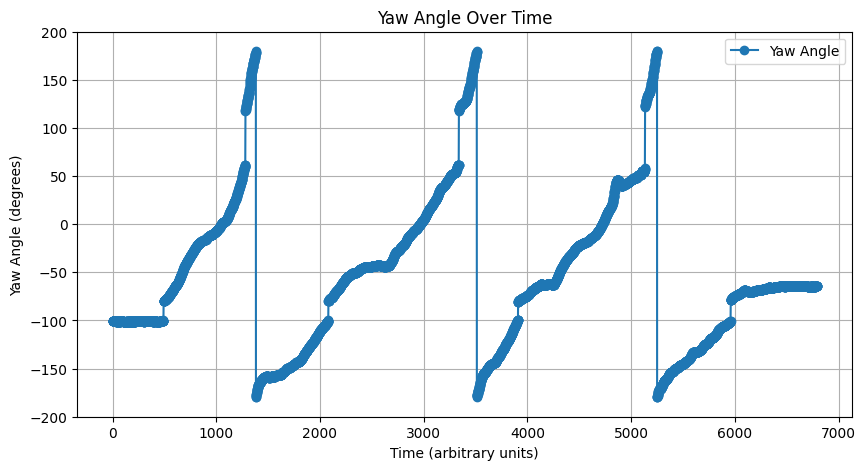

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(yaw_angles_unfiltered, label='Yaw Angle', marker='o', linestyle='-')
plt.title('Yaw Angle Over Time')
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Yaw Angle (degrees)')
plt.legend()
plt.grid(True)
plt.ylim(-200, 200)
#plt.savefig(r'plots\circles_unfiltered.png')
plt.show()

We can see that while the angle changes are relatively smooth in the unfiltered version, there are gaps in the measurements. Which is why this is a good time to bring the gyro into the mix.

### Filtered normally

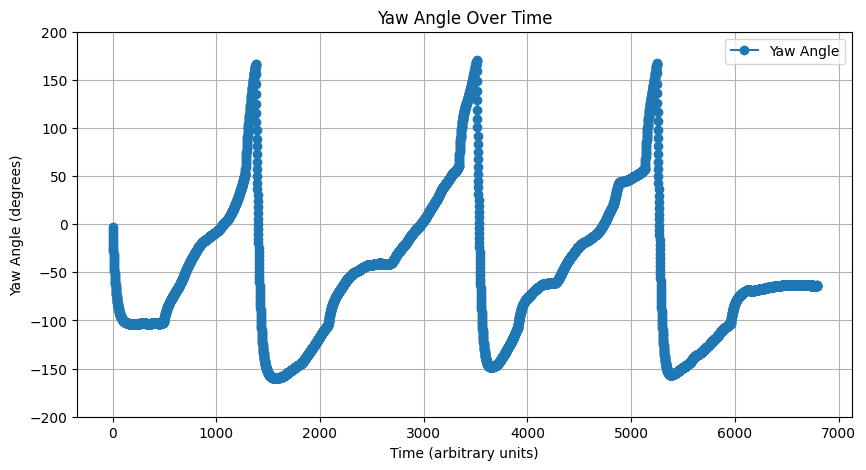

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(yaw_angles_filtered, label='Yaw Angle', marker='o', linestyle='-')
plt.title('Yaw Angle Over Time')
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Yaw Angle (degrees)')
plt.legend()
plt.grid(True)
plt.ylim(-200,200)
#plt.savefig(r'plots\circles_filtered_standard.png')
plt.show()

The gaps are nicely handled by the filter.
However the angle wraparound is causing some troubles. 

My quick and dirty solution is to turn the filter off for angles above |165| degrees. This of course is not a good way of doing so and normally one would probably get into Quaternions other more complicated means of representing rotation. 
If done correctly, this should remove the points between +-180

### Filtered with cutoff


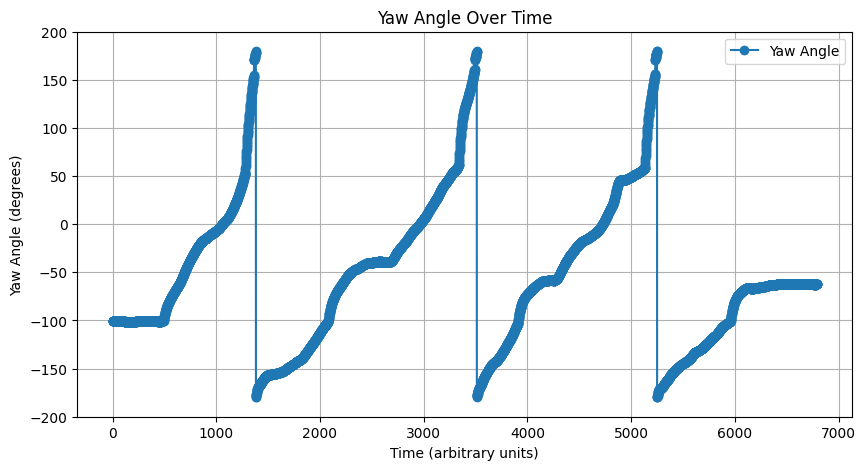

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(yaw_angles_filtered_cutoff, label='Yaw Angle', marker='o', linestyle='-')
plt.title('Yaw Angle Over Time')
plt.xlabel('Time (arbitrary units)')
plt.ylabel('Yaw Angle (degrees)')
plt.legend()
plt.grid(True)
plt.ylim(-200,200)
#plt.savefig(r'plots\circles_filtered_cutoff.png')
plt.show()

This is more like it. Overall a nice relatively smooth curve all around.

# Conclusion

Using this sort of ugly way of turning the filter off in the vicinity of the yaw_wraparound, we get the benefits of a filtered estimate without the wrong wraparound-measurements.

I capsuled this filter into a class and then used it for the IMU yaw estimation in my VIO setup.